In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info
Turns FFT result into power, basically `np.abs(fft)`. 
Expects 18-bit complex input and outputs a 36-bit float. 
Values near -1..1 may saturate the output.

# Examples

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 1024/1024 [00:00<00:00, 39153.36it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 1023)
INFO:sim:Hardware delay is 1


<IPython.core.display.Javascript object>


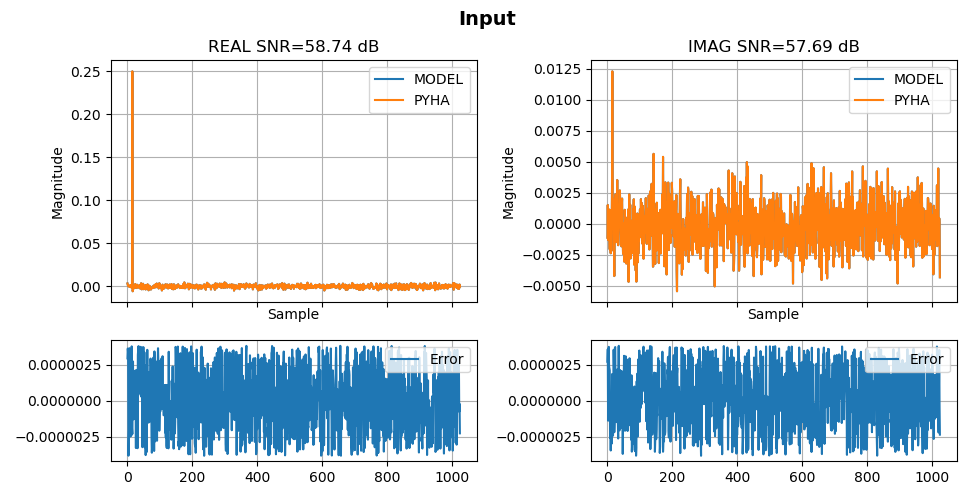

<IPython.core.display.Javascript object>


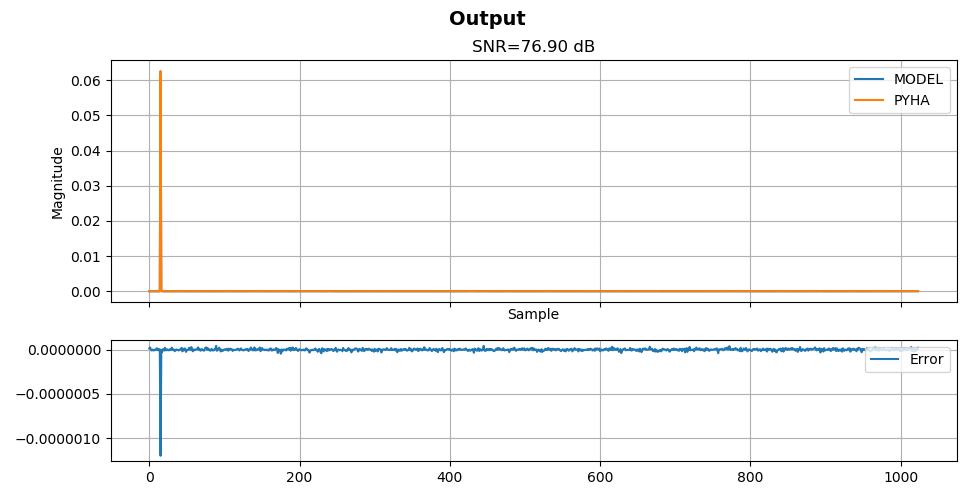

In [3]:
fft_size = 256
samples = 1024
freq = 15
sine = np.exp(2j*np.pi*np.linspace(0, 1, samples)*freq) * 0.25
noise = np.random.uniform(-1, 1, samples) + np.random.uniform(-1, 1, samples) * 1j
input_signal = sine + noise * 0.1
input_signal = np.fft.fft(input_signal) / len(input_signal)

dut = FFTPower()
sim = Simulator(dut, trace=True).run(input_signal)
sim.plot_trace()

# Conversion to VHDL and RTL/NETLIST simulations

In [4]:
# Pyha design can be converted to VHDL after the PYHA simulation has been ran
# VHDL sources can be used to run the RTL simulation, in addition NETLIST simulation is supported (after Quartus mapper)
# Pyha automatically manages everything needed if you specify the 'RTL', 'NETLIST' flags.
output_dir = '~/Documents/pyha_output'
dut = FFTPower()
vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(input_signal)
vhdl_sim.assert_equal(atol=1e-5, rtol=1e-5)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 1024/1024 [00:00<00:00, 11199.01it/s]
INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 1023)
INFO:sim:Hardware delay is 1
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:FFTPower to VHDL ...
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 1025/1025 [00:00<00:00, 1995.39it/s]

INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_eda quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No s

# Synthesis:  resource usage and Fmax

In [5]:
print(vhdl_sim.quartus.get_resource_usage('fit'))
print(vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 93 / 39,600 ( < 1 % )
    Total combinational functions : 93 / 39,600 ( < 1 % )
    Dedicated logic registers : 37 / 39,600 ( < 1 % )
Total registers : 37
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 0 / 1,161,216 ( 0 % )
Embedded Multiplier 9-bit elements : 4 / 232 ( 2 % )
Total PLLs : 0 / 4 ( 0 % )



/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory


----------------
; Fmax Summary ;
----------------
No paths to report.

